# Key papers

**TOPICS OF INTEREST** - from the meeting in January

* inflammation aging chronic (2004) - 13k papers
* genome editing / manipulation, CRISPR - 13k papers
* induced stem cells - 73k papers - 3h for calculating co-citations
* single-cell sequencing (2012) - 3k papers
* ATAC-seq (2015) - 276 papers
* immunomodulation cancer - 71k papers
* Telomere Theories of Aging - ??
* mTOR pathway - 14255
* autophagy - ??
* Calorie restriction - 3933

Complement Factor H + Age-Related Mascular Degeneration - investigate

**Issues**:

1. Some information in tooltips with long titles may occur out of plot bounds.
2. How should I place articles with the same year? (currently y-axis position is random in [0,1]...)
3. Some research on clustering algorithms is needed! (also `networkx.algorithms.community`)

**Functions**:

1. Subtopic Analysis based on co-citation graph clustering
2. Top Cited Papers detection (overall and for certain year)
3. Citation Dynamics for a certain article

## Search Terms

In [85]:
SEARCH_TERMS = ['dna', 'methylation', 'clock']

In [86]:
import logging
import re
import gc
import ipywidgets as widgets
import math
import networkx as nx
import numpy as np
import pandas as pd
import psycopg2 as pg_driver

from bokeh.io import push_notebook
from bokeh.models import ColumnDataSource, LabelSet, OpenURL, CustomJS
from bokeh.plotting import figure, show, output_notebook
from bokeh.transform import factor_cmap
from bokeh.core.properties import value
from bokeh.colors import Color, RGB
from bokeh.io import show
from bokeh.models import Plot, Range1d, MultiLine, Circle
# Tools used: hover,pan,tap,wheel_zoom,box_zoom,reset,save
from bokeh.models import HoverTool, PanTool, TapTool, WheelZoomTool, BoxZoomTool, ResetTool, SaveTool
from bokeh.models.graphs import from_networkx

from IPython.display import display
from matplotlib import pyplot as plt
%matplotlib inline

import nltk
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize 
import community
from Bio import Entrez

Entrez.email = 'nikolay.kapralov@gmail.com'
PUBMED_ARTICLE_BASE_URL = 'https://www.ncbi.nlm.nih.gov/pubmed/?term='

logging.basicConfig(format='%(asctime)s %(levelname)s: %(message)s', level=logging.DEBUG)
output_notebook()

nltk.download('stopwords')

2019-05-08 12:45:21,234 DEBUG: Loaded backend module://ipykernel.pylab.backend_inline version unknown.


Loading BokehJS ...

[nltk_data] Downloading package stopwords to /Users/oleg/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [87]:
class KeyPaperAnalyzer:       
    def __init__(self):
        self.conn = pg_driver.connect(dbname='pubmed', user='biolabs', password='pubtrends', host='localhost')
        self.cursor = self.conn.cursor()
        
    def load_publications(self):
        logging.info('Loading publication data')
        
        values = ', '.join(['({})'.format(i) for i in sorted(self.pmids)])
        query = re.sub('\$VALUES\$', values, '''
        DROP TABLE IF EXISTS TEMP_PMIDS;
        WITH vals(pmid) AS (VALUES $VALUES$)
        SELECT pmid INTO temporary table TEMP_PMIDS FROM vals;        
        DROP INDEX IF EXISTS temp_pmids_unique_index;
        CREATE UNIQUE INDEX temp_pmids_unique_index ON TEMP_PMIDS USING btree (pmid);

        SELECT P.pmid, P.title, P.year
        FROM Publications P
        JOIN TEMP_PMIDS AS T ON (P.pmid = T.pmid);
        ''')
        logging.info('Creating pmids table for request with index.')
        with self.conn:
            self.cursor.execute(query)
            
        pub_data = []
        for row in self.cursor:
            pub_data.append(list(row))
        self.pub_df = pd.DataFrame(pub_data, columns=['pmid', 'title', 'year'])
        logging.info(f'Found {len(self.pub_df)} publications in the local database')
            
    def load_cocitations(self):
        logging.info('Calculating co-citations for selected articles')
        # Use unfolding to pairs on the client side instead of DataBase        
        query = '''
        with Z as (select pmid_citing, pmid_cited
            from citations
            -- Hack to make Postgres use index!
            where pmid_cited between %s and %s
            and pmid_cited in (select pmid from TEMP_PMIDS)),
        X as (select pmid_citing, array_agg(pmid_cited) as cited_list
            from Z
            group by pmid_citing
            having count(*) >= 2)
        select X.pmid_citing, P.year, X.cited_list from
            X join publications P
            on pmid_citing = P.pmid;
        '''

        with self.conn:
            self.cursor.execute(query, (min(self.pmids), max(self.pmids), ))
            
        cocit_data = []
        lines = 0
        for row in self.cursor:
            lines += 1
            citing, year, cited = row
            for i in range(len(cited)):
                for j in range(i + 1, len(cited)):
                    cocit_data.append((citing, cited[i], cited[j], year))
        self.cocit_df = pd.DataFrame(cocit_data, columns=['citing', 'cited_1', 'cited_2', 'year'])
        logging.info(f'Loaded {lines} lines of citing info')
        logging.info(f'Found {len(self.cocit_df)} co-cited pairs of articles')

        logging.info(f'Building co-citations graph')
        self.cocit_grouped_df = self.cocit_df.groupby(['cited_1', 'cited_2', 'year']).count().reset_index()
        self.cocit_grouped_df = self.cocit_grouped_df.pivot_table(index=['cited_1', 'cited_2'], 
                                                          columns=['year'], values=['citing']).reset_index()
        self.cocit_grouped_df = self.cocit_grouped_df.replace(np.nan, 0)
        self.cocit_grouped_df['total'] = self.cocit_grouped_df.iloc[:, 2:].sum(axis=1)
        self.cocit_grouped_df = self.cocit_grouped_df.sort_values(by='total', ascending=False)
        logging.info('Filtering top 10000 or 80% of all the co-citations')
        self.cocit_grouped_df = self.cocit_grouped_df.iloc[:min(10000, round(0.8 * len(self.cocit_grouped_df))), :]
        self.CG = nx.Graph()
        # NOTE: we use nodes id as String to avoid problems str keys in jsonify during graph visualization
        for el in analyzer.cocit_grouped_df[['cited_1', 'cited_2', 'total']].values.astype(int):
            self.CG.add_edge(str(el[0]), str(el[1]), weight=el[2])
        logging.info(f'Co-citations graph nodes {len(self.CG.nodes())} edges {len(self.CG.edges())}')
            
    def load_citation_stats(self):
        logging.info('Started loading citation stats')

        query = '''
        with Z as (select pmid_citing, pmid_cited
        from citations
            -- Hack to make Postgres use index!
            where pmid_cited between %s and %s
            and pmid_cited in (select pmid from TEMP_PMIDS))
        select Z.pmid_cited, P.year, COUNT(1) from
        Z join publications P
        on Z.pmid_citing = P.pmid
            -- Hack to make Postgres use index!
            where Z.pmid_cited between %s and %s
            and P.year > 0
        GROUP BY Z.pmid_cited, P.year;
        '''

        with self.conn:
            self.cursor.execute(query, 
                                (min(self.pmids), max(self.pmids), min(self.pmids), max(self.pmids),))
        logging.info('Done loading citation stats')

        pub_data = []
        for row in analyzer.cursor:
            pub_data.append(list(row))
        self.cit_df = pd.DataFrame(pub_data, columns=['pmid', 'year', 'count'])
        
        self.cit_df = self.cit_df.pivot(index='pmid', columns='year', values='count').reset_index().replace(np.nan, 0)
        self.cit_df['total'] = self.cit_df.iloc[:, 1:].sum(axis = 1)
        self.cit_df = self.cit_df.sort_values(by='total', ascending=False)
        
        logging.info('Filtering top 10000 or 80% of all the papers')
        self.cit_df = self.cit_df.iloc[:min(10000, round(0.8 * len(self.cit_df))), :]
        logging.info('Done aggregation')
        
        logging.info(f"Loaded citation stats for {len(self.cit_df)} of {len(self.pmids)} articles. " +
                    "Others may either have zero citations or be absent in the local database.")        
            
    def plot_total_citations(self):
        plt.figure(figsize=(10, 5))
        ax = self.cit_df['total'].plot.bar()
        ax.set_xticklabels([])
        ax.set_xlabel('Articles')
        ax.set_ylabel('Number of citations')
    
    def search(self, *terms):
        print('TODO: handle queries which return more than 1000000 items')
        print('TODO: use local database instead of PubMed API')
        self.terms = [t.lower() for t in terms]
        query=' '.join(terms)
        handle = Entrez.esearch(db='pubmed', retmax='1000000', retmode='xml', term=query)
        self.pmids = [int(pmid) for pmid in Entrez.read(handle)['IdList']]
        logging.info(f'Found {len(self.pmids)} articles about {terms}')       
        
    def top_cited_papers(self, threshold=0.05):
        ids = self.cit_df.iloc[:round(len(self.cit_df) * threshold), 0].values
        counts = self.cit_df.iloc[:round(len(self.cit_df) * threshold), -1].values
        urls = [PUBMED_ARTICLE_BASE_URL + str(i) for i in ids]
        return zip(ids, urls, counts)

In [88]:
def build_data_source(df):
    # TODO: use d = ColumnDataSource(df)
    d = ColumnDataSource(data=dict(pmid=df['pmid'], title=df['title'], year=df['year'], total=df['total'],
                                   size=np.log(df['total']) / 10, pos=np.random.random(size=len(df))))
    return d

In [89]:
TOOLS = "hover,pan,tap,wheel_zoom,box_zoom,reset,save"

def serve_scatter_article_layout(source, title, year_range=None, color='blue'):
    callback = CustomJS(args=dict(source=source, base=PUBMED_ARTICLE_BASE_URL), code="""
        var data = source.data, selected = source.selected.indices;
        if (selected.length == 1) {
            // only consider case where one glyph is selected by user
            selected_id = data['pmid'][selected[0]]
            for (var i = 0; i < data['pmid'].length; ++i){
                if(data['pmid'][i] == selected_id){
                    window.open(base + data['pmid'][i], '_blank');
                }
            }
        }
    """)

    p = figure(tools=TOOLS, toolbar_location="above", plot_width=960, plot_height=400, x_range=year_range, title=title)
    p.xaxis.axis_label = 'Year'
    p.hover.tooltips = [
        ("PMID", '@pmid'),
        ("Title", '@title'),
        ("Year", '@year'),
        ("Cited by", '@total paper(s) total')
    ]
    p.js_on_event('tap', callback)

    p.circle(x='year', y='pos', fill_alpha=0.5, source=source, radius='size', line_color=color, fill_color=color)
    
    return p

def serve_citation_dynamics_layout():
    def update(b):
        try:
            pmid = int(text.value)
            data = analyzer.cit_df[analyzer.cit_df['pmid'] == pmid]
            if len(data) == 1:
                x = data.columns[1:-1].values.astype(int)
                y = data[x].values[0]
                bar.data_source.data = {'x': x, 'y': y}
            else:
                text.value = 'Bad ID'
            push_notebook(handle=h)
        except ValueError:
            text.value = ''

    title = "Number of Citations per Year"

    p = figure(tools=TOOLS, toolbar_location="above", plot_width=960, plot_height = 300, title=title)
    p.xaxis.axis_label = "Year"
    p.yaxis.axis_label = "Number of citations"
    p.hover.tooltips = [
        ("Year", "@x"),
        ("Cited by", "@y paper(s) in @x"),
    ]

    d = ColumnDataSource(data=dict(x=[], y=[]))
    bar = p.vbar(x='x', width=0.8, top='y', source=d, color='#A6CEE3', line_width=3)
    
    text = widgets.Text(
        value='',
        placeholder='Enter PMID',
        description='PMID:',
        disabled=False
    )

    button = widgets.Button(
        description='Show',
        disabled=False,
        button_style='info',
        tooltip='Show'
    )
    button.on_click(update)

    panel = widgets.HBox([text, button])

    display(panel)
    h = show(p, notebook_handle=True)
    
    return p, h, panel

In [90]:
from collections import Counter

NUM_MOST_COMMON = 5

def get_ngrams(string):
    stop_words = set(stopwords.words('english')) 
    tokens = list(filter(lambda s: any(c.isalpha() for c in s), string.lower().replace(',', '').replace('.', '').split(' ')))
    tokens = [t for t in tokens if t not in stop_words and t not in analyzer.terms]
    ngrams = list(tokens)
    for t1, t2 in zip(tokens[:-1], tokens[1:]):
        ngrams.append(t1 + ' ' + t2)
    for t1, t2, t3 in zip(tokens[:-2], tokens[1:-1], tokens[2:]):
        ngrams.append(t1 + ' ' + t2 + ' ' + t3)
    return ngrams

def get_most_common_ngrams(titles):
    ngrams = []
    for title in titles:
        ngrams.extend(get_ngrams(title))
    most_common = {}
    for ngram, cnt in Counter(ngrams).most_common(NUM_MOST_COMMON):
        most_common[ngram] = cnt / len(titles)
    return most_common

In [91]:
analyzer = KeyPaperAnalyzer()
analyzer.search(*SEARCH_TERMS)
analyzer.load_publications()
# analyzer.pub_df.head()

TODO: handle queries which return more than 1000000 items
TODO: use local database instead of PubMed API


2019-05-08 12:45:22,172 INFO: Found 295 articles about ('dna', 'methylation', 'clock')
2019-05-08 12:45:22,173 INFO: Loading publication data
2019-05-08 12:45:22,174 INFO: Creating pmids table for request with index.
2019-05-08 12:45:22,196 INFO: Found 286 publications in the local database


In [92]:
# In case this command is too long, you can stop and start DB
# pg_ctl -D /usr/local/var/postgres stop -s -m fast
# pg_ctl -D /usr/local/var/postgres -l /usr/local/var/postgres/server.log start
analyzer.load_cocitations()
# analyzer.cocit_df.head()

2019-05-08 12:45:22,205 INFO: Calculating co-citations for selected articles
2019-05-08 12:45:22,283 INFO: Loaded 601 lines of citing info
2019-05-08 12:45:22,284 INFO: Found 8826 co-cited pairs of articles
2019-05-08 12:45:22,285 INFO: Building co-citations graph
2019-05-08 12:45:22,318 INFO: Filtering top 10000 or 80% of all the co-citations
2019-05-08 12:45:22,330 INFO: Co-citations graph nodes 166 edges 1596


In [93]:
analyzer.load_citation_stats()
# analyzer.cit_df.head()

2019-05-08 12:45:22,337 INFO: Started loading citation stats
2019-05-08 12:45:22,408 INFO: Done loading citation stats
2019-05-08 12:45:22,418 INFO: Filtering top 10000 or 80% of all the papers
2019-05-08 12:45:22,419 INFO: Done aggregation
2019-05-08 12:45:22,420 INFO: Loaded citation stats for 167 of 295 articles. Others may either have zero citations or be absent in the local database.


In [94]:
df_all = pd.merge(analyzer.pub_df, analyzer.cit_df, on='pmid')

## Subtopics a.k.a. Clusters in the Co-citation Graph

In [95]:
logging.info(f'Louvain community clustering of co-citation graph')
p = community.best_partition(analyzer.CG)
components = set(p.values())
logging.info(f'Found {len(components)} components')
# q = list(greedy_modularity_communities(analyzer.CG))

2019-05-08 12:45:22,436 INFO: Louvain community clustering of co-citation graph
2019-05-08 12:45:22,556 INFO: Found 7 components


In [96]:
# This will limit total number of components
GRANULARITY = 0.01
logging.info(f'Merging components smaller than {GRANULARITY} to "Other" component')
threshold = int(GRANULARITY * len(p))
comp_sizes = {com: sum([p[node] == com for node in p.keys()]) for com in components}
comp_to_merge = {com: comp_sizes[com] <= threshold for com in components}
if sum(comp_to_merge.values()) > 0:
    logging.info(f'Reassigning components, component 0 is "Other"')
    pm = {}
    newcomps = {}
    ci = 1 # Other component is 0.
    for k, v in p.items():
        if comp_sizes[v] <= threshold:
            pm[k] = 0 # Other
            continue
        if v not in newcomps:
            newcomps[v] = ci
            ci += 1
        pm[k] = newcomps[v]
    logging.info(f'Processed {len(set(pm.values()))} components')
else:
    pm = p
components = set(pm.values())    
pmcomp_sizes = {com: sum([pm[node] == com for node in pm.keys()]) for com in components}
logging.info('\n'.join([f'{k}: {v} ({int(100 * v / len(pm))}%)' for k,v in pmcomp_sizes.items()]))

2019-05-08 12:45:22,567 INFO: Merging components smaller than 0.01 to "Other" component
2019-05-08 12:45:22,569 INFO: 0: 37 (22%)
1: 51 (30%)
2: 58 (34%)
3: 4 (2%)
4: 10 (6%)
5: 4 (2%)
6: 2 (1%)


In [97]:
%time

logging.info('Visualize components')

G = analyzer.CG.copy()

cmap = plt.cm.get_cmap('nipy_spectral', len(set(pm.values())))
comp_palette = [RGB(*[round(c*255) for c in cmap(i)[:3]]) for i in range(len(set(pm.values())))]

# set node attributes
node_color = {node: comp_palette[pm[node]] for node in G.nodes()}
nx.set_node_attributes(G, node_color, 'colors')

# Show with Bokeh
plot = Plot(plot_width=400, plot_height=400, x_range=Range1d(-1.1, 1.1), y_range=Range1d(-1.1, 1.1))
plot.title.text = 'Components visualization'

graph = from_networkx(G, nx.spring_layout, scale=1, center=(0, 0))
graph.node_renderer.glyph = Circle(size=5, fill_color='colors')

# add data for rendering
graph.node_renderer.data_source.data['id'] = list(G.nodes())

# add tools to the plot
# hover,pan,tap,wheel_zoom,box_zoom,reset,save
plot.add_tools(HoverTool(tooltips=[("Id", "@id")]), 
               PanTool(), WheelZoomTool(), BoxZoomTool(), ResetTool(), SaveTool())

plot.renderers.append(graph)

show(plot)

2019-05-08 12:45:22,587 INFO: Visualize components


CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 8.11 µs


In [98]:
pm_ints = {int(k): v for k,v in pm.items()}
df_comp = pd.Series(pm_ints).reset_index().rename(columns={'index': 'pmid', 0: 'comp'})
df_all = pd.merge(df_all, df_comp, on='pmid')
# df_all.head()

In [99]:
years = df_all.columns.values[3:-2].astype(int)
min_year, max_year = np.min(years), np.max(years)

In [100]:
logging.info('Summary component detailed info visualization')

n_comps = df_all['comp'].nunique()
cmap = plt.cm.get_cmap('nipy_spectral', n_comps)
palette = [RGB(*[round(c*255) for c in cmap(i)[:3]]) for i in range(n_comps)]

components = [str(i) for i in range(n_comps)]
years = [str(y) for y in range(min_year, max_year)]
data = {'years': years}
for c in range(n_comps):
    data[str(c)] = [len(df_all[np.logical_and(df_all['comp'] == c, df_all['year'] == y)]) \
                    for y in range(min_year, max_year)]

p = figure(x_range=years, plot_width=960, plot_height=300, title="Components by Year",
           toolbar_location=None, tools="hover", tooltips="#$name: @$name")

p.vbar_stack(components, x='years', width=0.9, color=palette, source=data, alpha=0.5,
             legend=[value(c) for c in components])

p.y_range.start = 0
p.x_range.range_padding = 0.1
p.xgrid.grid_line_color = None
p.axis.minor_tick_line_color = None
p.outline_line_color = None
p.legend.location = "top_left"
p.legend.orientation = "horizontal"

show(p)

2019-05-08 12:45:22,940 INFO: Summary component detailed info visualization


In [101]:
logging.info('Per component detailed info visualization')
n_comps = df_all['comp'].nunique()
ds = [None] * n_comps
layouts = [None] * n_comps
most_common = [None] * n_comps
cmap = plt.cm.get_cmap('nipy_spectral', n_comps)
for c in range(n_comps):
    ds[c] = build_data_source(df_all[df_all['comp'] == c])
    most_common[c] = dict(get_most_common_ngrams(df_all[df_all['comp'] == c]['title'].values))
    kwd = ', '.join([f'{k} ({v:.2f})' for k, v in most_common[c].items()])
    title = f'Subtopic #{c}: {kwd}'
    layouts[c] = serve_scatter_article_layout(ds[c], title, year_range=[min_year, max_year], 
                                              color=RGB(*[round(ch*255) for ch in cmap(c)[:3]]))
    show(layouts[c])

2019-05-08 12:45:23,469 INFO: Per component detailed info visualization


## Top Cited Papers Overall

In [102]:
df_all = df_all.sort_values(by='total', ascending=False)

In [103]:
THRESHOLD = 0.1 # 10 %
MAX_PAPERS = 20

In [104]:
print('TODO: color me by components colors')
papers_to_show = min(MAX_PAPERS, round(len(analyzer.cit_df) * THRESHOLD))


ds_top = build_data_source(df_all.iloc[:papers_to_show, :])
layout_top = serve_scatter_article_layout(ds_top, 'Top cited papers', year_range=[min_year, max_year])
show(layout_top)

logging.info('Top cited papers in total')
df_all.sort_values('total', axis=0, ascending = False)[['pmid', 'title', 'year', 'total']].head(papers_to_show)

TODO: color me by components colors


2019-05-08 12:45:25,328 INFO: Top cited papers in total


,pmid,title,year,total
44,24138928,DNA methylation age of human tissues and cell ...,2013,629.0
53,25313081,Obesity accelerates epigenetic aging of human ...,2014,139.0
3,15790588,"Deregulated expression of the PER1, PER2 and P...",2005,119.0
61,25617346,The epigenetic clock is correlated with physic...,2015,110.0
1,2777259,Cytosine methylation and the fate of CpG dinuc...,1989,103.0
4,15860628,PERIOD1-associated proteins modulate the negat...,2005,97.0
66,25969563,HIV-1 Infection Accelerates Age According to t...,2015,94.0
65,25913071,DNA methylation and healthy human aging.,2015,93.0
101,27690265,DNA methylation-based measures of biological a...,2016,92.0
30,22438023,Genome-wide analysis of DNA methylation and ge...,2012,90.0


## Top Cited Papers for Each Year

In [105]:
max_gain_data = []
cols = df_all.columns[3:-2]
for i in range(len(cols)):
    max_gain = df_all[cols[i]].astype(int).max()
    if max_gain > 0:
        sel = df_all[df_all[cols[i]] == max_gain]
        max_gain_data.append([cols[i], sel['pmid'].values[0], 
                              sel['title'].values[0], max_gain])
        
max_gain_df = pd.DataFrame(max_gain_data, columns=['year', 'pmid', 'title', 'count'])
max_gain_df.head(20)

ds_max = ColumnDataSource(data=dict(year=max_gain_df['year'], pmid=max_gain_df['pmid'].astype(str),
                                   title=max_gain_df['title'], count=max_gain_df['count']))
factors=max_gain_df['pmid'].astype(str).unique()
cmap = plt.cm.get_cmap('nipy_spectral', len(factors))
palette = [RGB(*[round(c*255) for c in cmap(i)[:3]]) for i in range(len(factors))]
colors = factor_cmap('pmid', palette=palette, factors=factors)

year_range = [min_year, max_year]
p = figure(tools=TOOLS, toolbar_location="above", 
           plot_width=960, plot_height=300, x_range=year_range, title='Max gain')
p.xaxis.axis_label = 'Year'
p.yaxis.axis_label = 'Number of citations'
p.hover.tooltips = [
    ("PMID", '@pmid'),
    ("Title", '@title'),
    ("Year", '@year'),
    ("Cited by", '@count papers in @year')
]

p.vbar(x='year', width=0.8, top='count', fill_alpha=0.5, source=ds_max, fill_color=colors, line_color=colors)
logging.info('Different colors encode different papers')
show(p)

2019-05-08 12:45:25,399 INFO: Different colors encode different papers


## Citation per Year Dynamics

In [106]:
logging.info('Enter ID to get detailed citations timeline')
p, h, panel = serve_citation_dynamics_layout()

2019-05-08 12:45:25,640 INFO: Enter ID to get detailed citations timeline


## Component Evolution

In [107]:
cocit_df = analyzer.cocit_df.copy()
min_year = cocit_df['year'].min().astype(int)
max_year = cocit_df['year'].max().astype(int)
print(f'Cocitation year range: {min_year} - {max_year}')

Cocitation year range: 2006 - 2019


In [108]:
YEAR_STEP = 2

evolution_series = []
year_range = range(max_year, min_year-1, -YEAR_STEP)
print('Filtering top 10000 or 80% of all the co-citations')
for year in range(max_year, min_year-1, -YEAR_STEP):   
    cocit_grouped_df = cocit_df[cocit_df['year'] <= year].groupby(['cited_1', 'cited_2', 'year']).count().reset_index()
    cocit_grouped_df = cocit_grouped_df.pivot_table(index=['cited_1', 'cited_2'], 
                                                    columns=['year'], values=['citing']).reset_index()
    cocit_grouped_df = cocit_grouped_df.replace(np.nan, 0)
    cocit_grouped_df['total'] = cocit_grouped_df.iloc[:, 2:].sum(axis=1)
    cocit_grouped_df = cocit_grouped_df.sort_values(by='total', ascending=False)
    cocit_grouped_df = cocit_grouped_df.iloc[:min(10000, round(0.8 * len(cocit_grouped_df))), :]
    
    CG = nx.Graph()
    # NOTE: we use nodes id as String to avoid problems str keys in jsonify during graph visualization
    for el in cocit_grouped_df[['cited_1', 'cited_2', 'total']].values.astype(int):
        CG.add_edge(str(el[0]), str(el[1]), weight=el[2])
    print(f'{year} - {len(CG.nodes)} nodes, {len(CG.edges)} edges') 
    
    p = {int(vertex): int(comp) for vertex, comp in community.best_partition(CG).items()}
    evolution_series.append(pd.Series(p))

Filtering top 10000 or 80% of all the co-citations
2019 - 166 nodes, 1596 edges
2017 - 118 nodes, 770 edges
2015 - 70 nodes, 269 edges
2013 - 35 nodes, 55 edges
2011 - 19 nodes, 30 edges
2009 - 13 nodes, 16 edges
2007 - 7 nodes, 6 edges


In [109]:
SHIFT = True # use random shift to see trace of separate articles
FILLNA = True # NaN values sometimes cause KeyError while plotting, but sometimes not (?!)

evolution_df = pd.concat(evolution_series, axis=1).rename(columns=dict(enumerate(year_range)))
evolution_df['current'] = evolution_df[max_year]
evolution_df = evolution_df[list(reversed(list(evolution_df.columns)))]

if SHIFT:
    shift = np.random.uniform(0.25, 0.75, size=(len(evolution_df),))
    for year in year_range:
        evolution_df[year] += shift
        
if FILLNA:
    evolution_df = evolution_df.fillna(-1.0)

evolution_df.head()

,current,2007,2009,2011,2013,2015,2017,2019
1722018,4.0,0.306113,0.306113,0.306113,2.306113,3.306113,3.306113,4.306113
2777259,5.0,-1.000000,2.567202,-1.000000,4.567202,5.567202,5.567202,5.567202
14577056,4.0,-1.000000,-1.000000,-1.000000,2.306131,3.306131,3.306131,4.306131
15790588,3.0,1.722411,1.722411,2.722411,1.722411,2.722411,2.722411,3.722411
15860628,3.0,1.679600,1.679600,1.679600,0.679600,1.679600,2.679600,3.679600


2019-05-08 12:45:26,909 DEBUG: update_title_pos
2019-05-08 12:45:26,996 DEBUG: update_title_pos
2019-05-08 12:45:27,142 DEBUG: update_title_pos
2019-05-08 12:45:27,225 DEBUG: update_title_pos
2019-05-08 12:45:27,279 DEBUG: update_title_pos


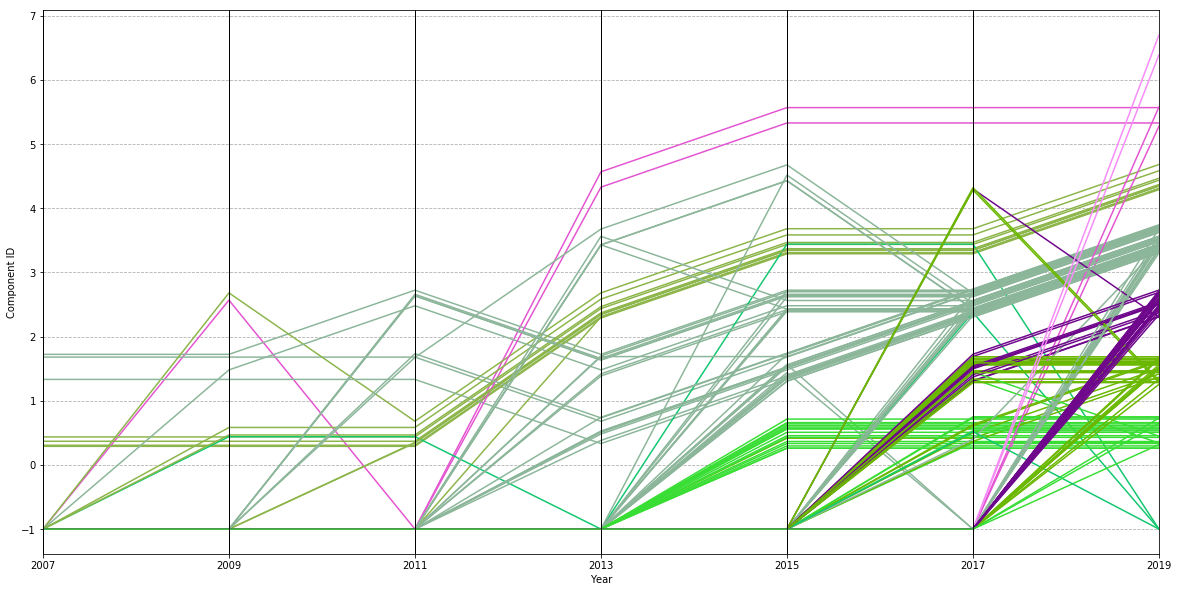

In [110]:
plt.rcParams['figure.figsize'] = 20, 10
pd.plotting.parallel_coordinates(evolution_df, 'current', sort_labels=True)
plt.xlabel('Year')
plt.ylabel('Component ID')
plt.grid(b=True, which='both', linestyle='--')
plt.legend().set_visible(False)